# 🚀 Required EDA for Your Satellite Image Dataset (Based on Project Document)

Import Needed Libs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from skimage.feature import graycomatrix, graycoprops
import umap
from xgboost import XGBClassifier


Import Data From Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/EuroSAT_Final_Dataset/"
# X = np.load(data_path + "X.npy")
# y = np.load(data_path + "y.npy")
# NDVI = np.load(data_path + "NDVI.npy")
X = np.load(data_path + "X.npy", mmap_mode='r')  # Prevents full dataset load into RAM
y = np.load(data_path + "y.npy", mmap_mode='r')
NDVI = np.load(data_path + "NDVI.npy", mmap_mode='r')

print("X shape:", X.shape)
print("y shape:", y.shape)
print("NDVI shape:", NDVI.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X shape: (40000, 64, 64, 4)
y shape: (40000,)
NDVI shape: (40000, 64, 64)


## 1️⃣ Dataset Summary & Composition

✔ Total images count and distribution by land type (Agriculture, Water, Urban, etc.).


In [3]:
label_mapping = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

y_named = np.vectorize(label_mapping.get)(y)

Total Images: 40000


<ipython-input-4-cec5519f5717>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Land_Type'], palette="viridis")


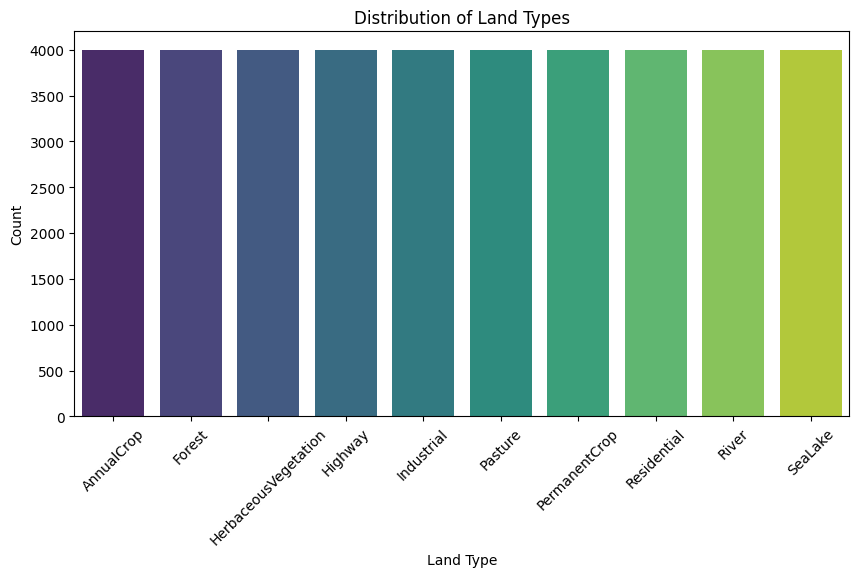

In [4]:
df = pd.DataFrame(y_named, columns=['Land_Type'])

total_images = len(y)
print(f"Total Images: {total_images}")

# ✔ Distribution of land types
plt.figure(figsize=(10, 5))
sns.countplot(x=df['Land_Type'], palette="viridis")
plt.title("Distribution of Land Types")
plt.xlabel("Land Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


  ✔ Check for missing values or mislabeled images.

In [5]:
missing_values = df.isnull().sum()
print("Missing Values Per Column:\n", missing_values)

Missing Values Per Column:
 Land_Type    0
dtype: int64


  ✔ Ensure balanced class distribution to avoid bias in training

In [6]:
unique_labels = df['Land_Type'].unique()
print(f"Unique Land Types in Dataset: {unique_labels}")

Unique Land Types in Dataset: ['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


## 2️⃣ Spectral Band Analysis
✔ Histogram for pixel intensity in each spectral band (Red, Green, Blue, NIR, SWIR, etc.).

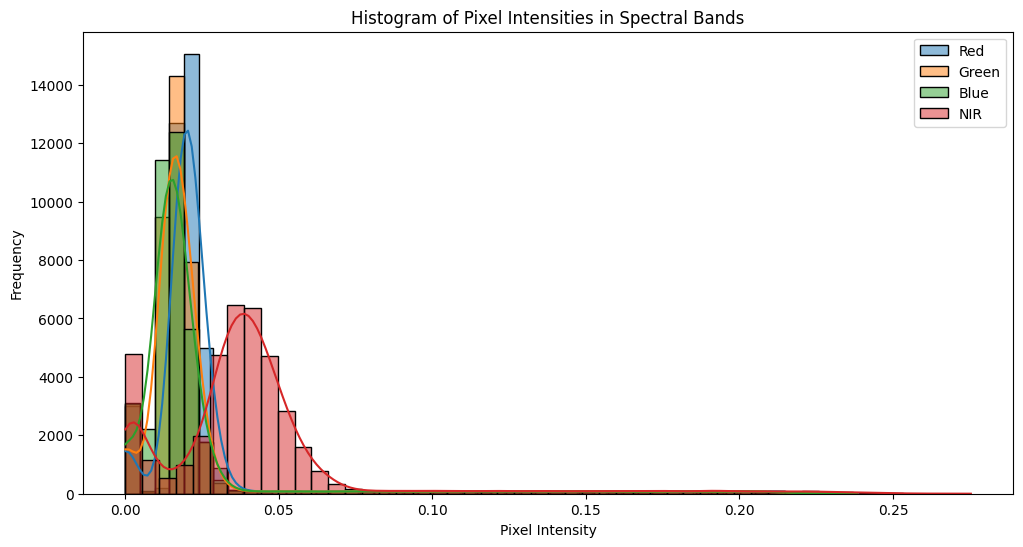

In [7]:
bands = ["Red", "Green", "Blue", "NIR"]
num_samples, height, width, num_bands = X.shape

X_reshaped = X.reshape(num_samples, -1, num_bands).mean(axis=1)
df_bands = pd.DataFrame(X_reshaped, columns=bands)

plt.figure(figsize=(12, 6))
for band in bands:
    sns.histplot(df_bands[band], kde=True, bins=50, label=band)
plt.legend()
plt.title("Histogram of Pixel Intensities in Spectral Bands")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

✔ Correlation matrix between spectral bands to find relationships.

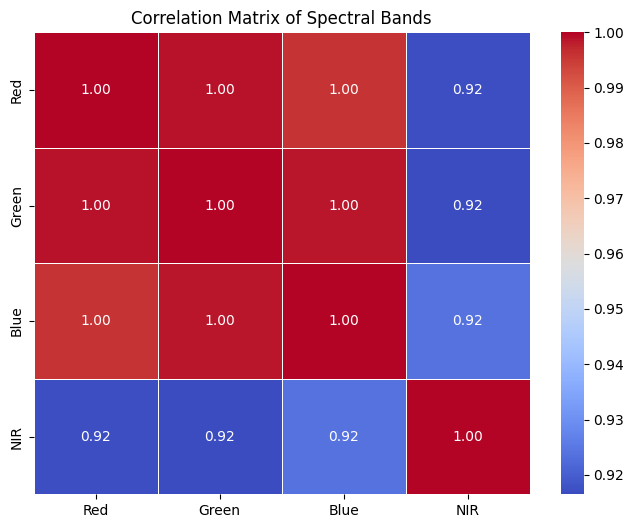

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_bands.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Spectral Bands")
plt.show()

✔ Boxplots for NDVI (Normalized Difference Vegetation Index) to differentiate vegetation types.


<ipython-input-9-8c358f4221ca>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Land Type", y="NDVI Mean", data=ndvi_df, palette="viridis")


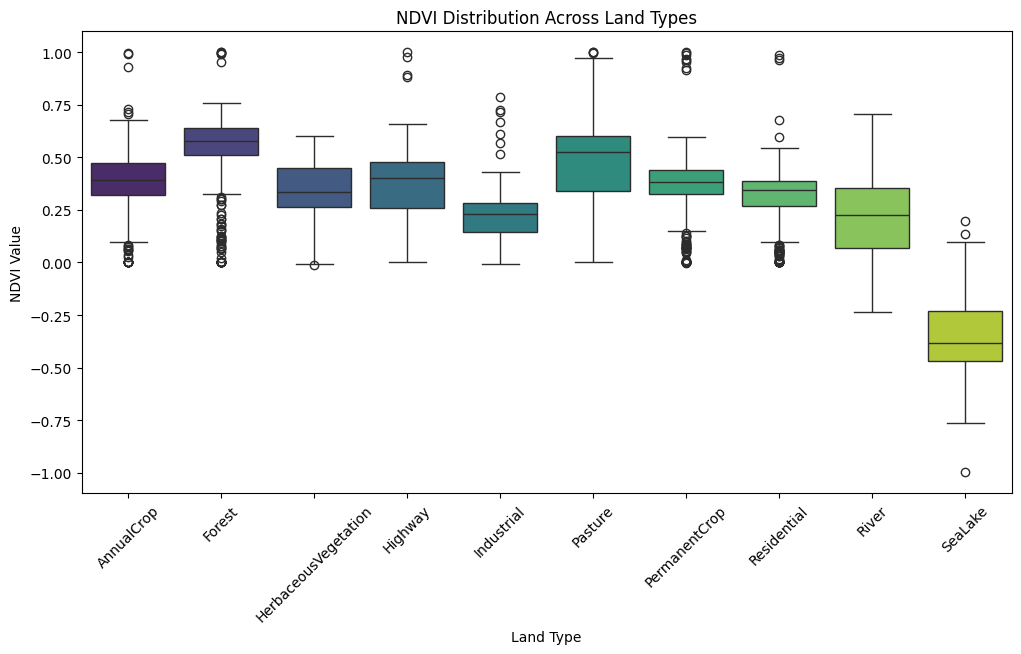

In [9]:
samples_per_class =500
selected_indices = []

for land_type in np.unique(y_named):
    indices = np.where(y_named == land_type)[0]
    selected_indices.extend(np.random.choice(indices, min(len(indices), samples_per_class), replace=False))

NDVI_selected = NDVI[selected_indices]

ndvi_df = pd.DataFrame({
    "NDVI Mean": NDVI_selected.mean(axis=(1, 2)),
    "Land Type": y_named[selected_indices]
})

plt.figure(figsize=(12, 6))
sns.boxplot(x="Land Type", y="NDVI Mean", data=ndvi_df, palette="viridis")
plt.title("NDVI Distribution Across Land Types")
plt.xlabel("Land Type")
plt.ylabel("NDVI Value")
plt.xticks(rotation=45)
plt.show()

## 3️⃣ Image Quality & Preprocessing Checks
✔ Check resolution variations (Are images consistent in size?).



In [10]:
image_shapes = [img.shape for img in X]
unique_shapes = set(image_shapes)
print(f"Unique image resolutions in dataset: {unique_shapes}")

Unique image resolutions in dataset: {(64, 64, 4)}


✔ Apply PCA (Principal Component Analysis) to analyze redundancy in spectral bands.


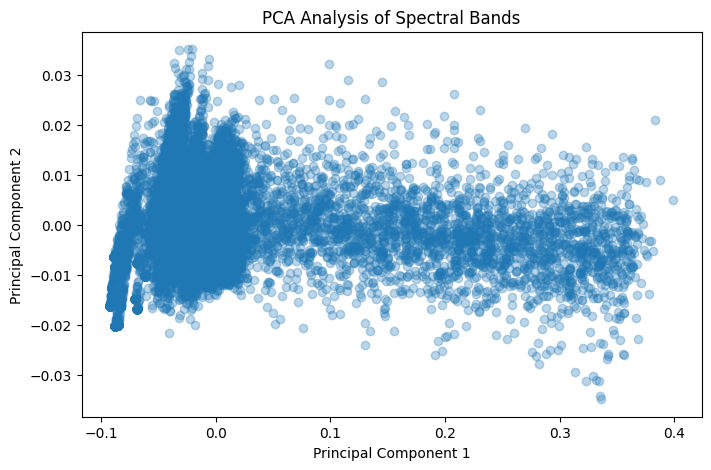

In [11]:
batch_size=1000
num_batches = num_samples // batch_size + 1  # Calculate number of batches
pca = PCA(n_components=2)
X_pca_batches = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples)

    if start_idx >= num_samples:
        break  # Avoid indexing error

    X_batch = X[start_idx:end_idx].reshape(end_idx - start_idx, -1, num_bands).mean(axis=1)  # Reduce spatial dimension
    X_pca_batches.append(pca.fit_transform(X_batch))  # Apply PCA

X_pca = np.vstack(X_pca_batches)  # Combine batches

# PCA Visualization
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Analysis of Spectral Bands")
plt.show()


✔ Visualize sample images from different land types to understand spectral signatures.

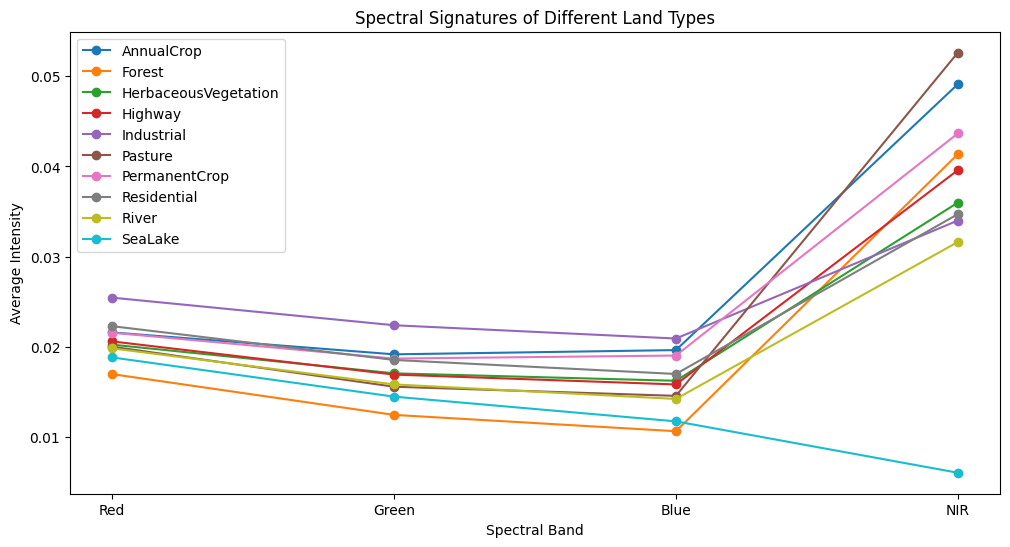

In [12]:
num_samples=1000
unique_labels = df['Land_Type'].unique()
sample_images = {}

for land_type in unique_labels:
    indices = df[df['Land_Type'] == land_type].index[:num_samples]
    sample_images[land_type] = X[indices]

plt.figure(figsize=(12, 6))
for land_type, images in sample_images.items():
    avg_spectral = images.mean(axis=(0, 1, 2))
    plt.plot(bands, avg_spectral, marker="o", label=land_type)

plt.xlabel("Spectral Band")
plt.ylabel("Average Intensity")
plt.title("Spectral Signatures of Different Land Types")
plt.legend()
plt.show()

In [13]:
print(f"Min pixel value: {X.min()}, Max pixel value: {X.max()}")


Min pixel value: 0.0, Max pixel value: 0.6359816638496385


We Shocked when we found the imgs plot as black.

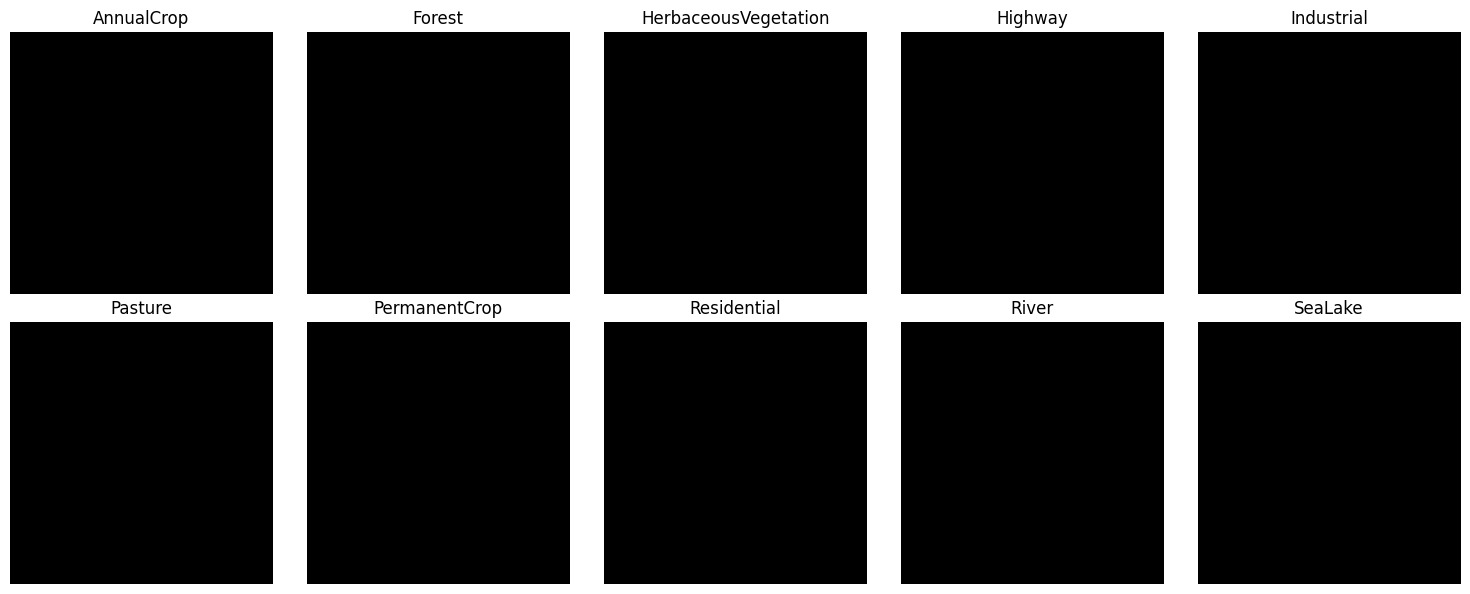

In [87]:
# Visualize sample images from different land types
unique_labels = df['Land_Type'].unique()
num_classes = len(unique_labels)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

for i, land_type in enumerate(unique_labels[:10]):
    idx = np.where(df['Land_Type'] == land_type)[0][0]
    image = X[idx, :, :, :3]

    axes[i].imshow(image.astype(np.uint8))
    axes[i].set_title(land_type)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


We Shocked when we found the imgs plot as black, so we made some edits to be more clear.

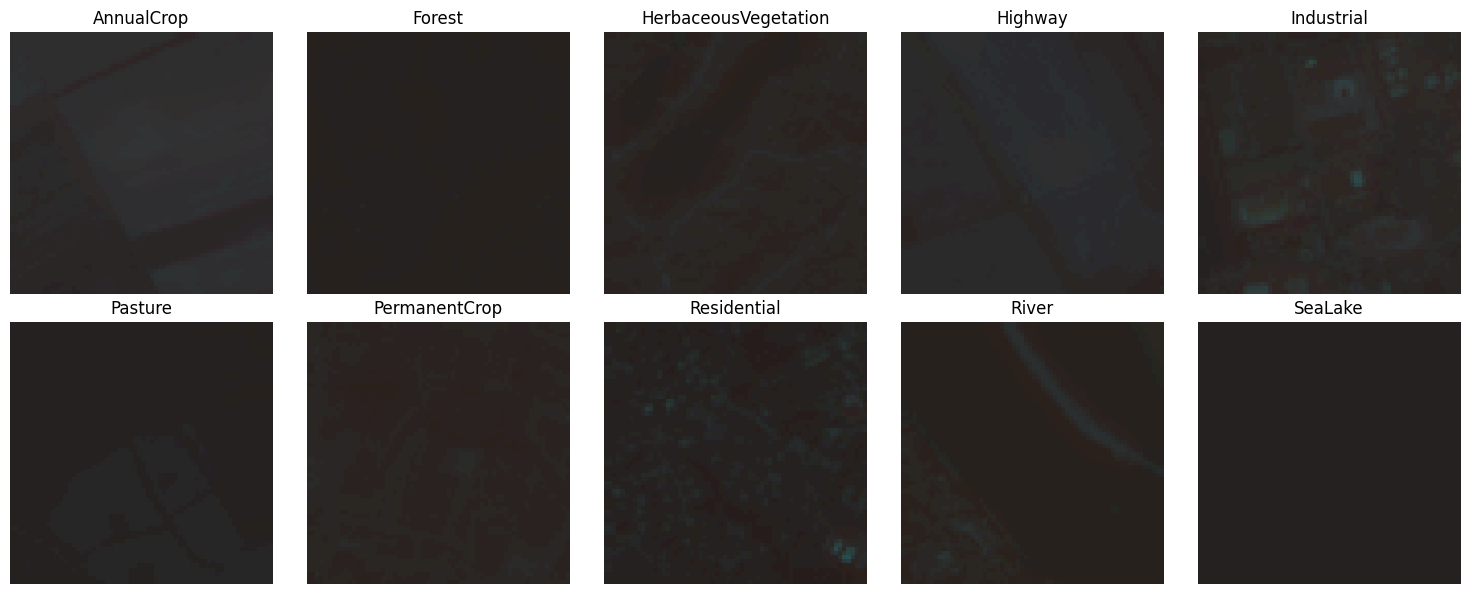

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

for i, land_type in enumerate(unique_labels[:10]):
    idx = np.where(df['Land_Type'] == land_type)[0][0]
    image = X[idx, :, :, :3]
    #-------------------------------------------------------#
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    # Apply gamma correction
    gamma = 2.2
    image = np.power(image / 255.0, 1/gamma) * 255
    image = np.clip(image, 0, 255).astype(np.uint8)
    #-------------------------------------------------------#

    axes[i].imshow(image)
    axes[i].set_title(land_type)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


we discovered  that bands are not arranged correctly.

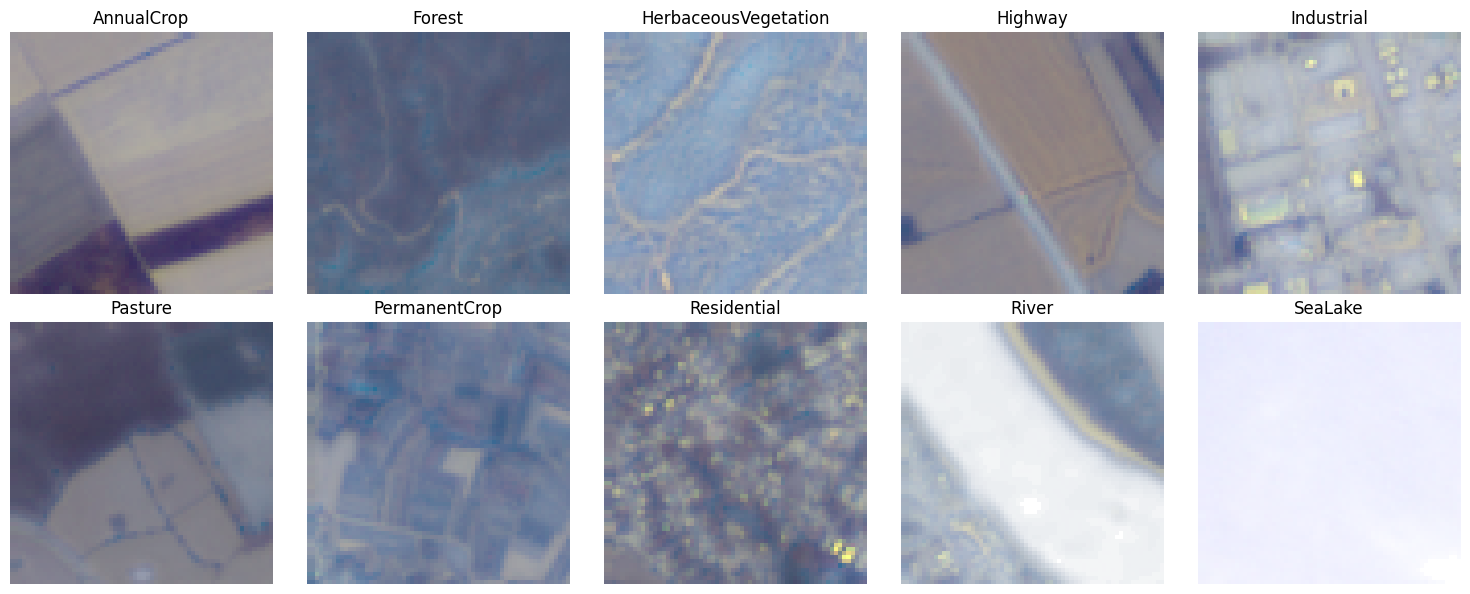

In [125]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

for i, land_type in enumerate(unique_labels[:10]):
    idx = np.where(df['Land_Type'] == land_type)[0][0]
    image = X[idx]
    #-------------------------------------------------------#

    image = (image - image.min()) / (image.max() - image.min())

    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    gamma = 2.2
    image = np.power(image / 255.0, 1/gamma) * 255
    image = np.clip(image, 0, 255).astype(np.uint8)
    image = image[:, :,  [2, 1, 0, 3]]  # Convert from BGR to RGB (if needed)     <-------------- this is the code that solved the issue.

    #-------------------------------------------------------#

    axes[i].imshow(image)
    axes[i].set_title(land_type)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [126]:
final_dataset_path = "/content/drive/My Drive/EuroSAT_Final_Dataset"  #


# Process the entire dataset
X_processed = np.empty_like(X, dtype=np.uint8)

for i in range(len(X)):
    image = X[i].astype(np.float32)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize

    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    # Apply gamma correction
    gamma = 2.2
    image = np.power(image / 255.0, 1/gamma) * 255
    image = np.clip(image, 0, 255).astype(np.uint8)

    # Convert BGR to RGB
    X_processed[i] = image[:, :,  [2, 1, 0, 3]]
    print(f"Dataset updated and saved img no.{i} successfully!")
# Save the processed dataset
np.save(os.path.join(final_dataset_path, "X.npy"), X_processed)

print("Dataset updated and saved successfully!")


Dataset updated and saved img no.0 successfully!
Dataset updated and saved img no.1 successfully!
Dataset updated and saved img no.2 successfully!
Dataset updated and saved img no.3 successfully!
Dataset updated and saved img no.4 successfully!
Dataset updated and saved img no.5 successfully!
Dataset updated and saved img no.6 successfully!
Dataset updated and saved img no.7 successfully!
Dataset updated and saved img no.8 successfully!
Dataset updated and saved img no.9 successfully!
Dataset updated and saved img no.10 successfully!
Dataset updated and saved img no.11 successfully!
Dataset updated and saved img no.12 successfully!
Dataset updated and saved img no.13 successfully!
Dataset updated and saved img no.14 successfully!
Dataset updated and saved img no.15 successfully!
Dataset updated and saved img no.16 successfully!
Dataset updated and saved img no.17 successfully!
Dataset updated and saved img no.18 successfully!
Dataset updated and saved img no.19 successfully!
Dataset up

<ipython-input-126-6f3bc42a7299>:9: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min())  # Normalize
<ipython-input-126-6f3bc42a7299>:17: RuntimeWarning: invalid value encountered in cast
  image = np.clip(image, 0, 255).astype(np.uint8)


Streaming output truncated to the last 5000 lines.
Dataset updated and saved img no.35001 successfully!
Dataset updated and saved img no.35002 successfully!
Dataset updated and saved img no.35003 successfully!
Dataset updated and saved img no.35004 successfully!
Dataset updated and saved img no.35005 successfully!
Dataset updated and saved img no.35006 successfully!
Dataset updated and saved img no.35007 successfully!
Dataset updated and saved img no.35008 successfully!
Dataset updated and saved img no.35009 successfully!
Dataset updated and saved img no.35010 successfully!
Dataset updated and saved img no.35011 successfully!
Dataset updated and saved img no.35012 successfully!
Dataset updated and saved img no.35013 successfully!
Dataset updated and saved img no.35014 successfully!
Dataset updated and saved img no.35015 successfully!
Dataset updated and saved img no.35016 successfully!
Dataset updated and saved img no.35017 successfully!
Dataset updated and saved img no.35018 successfu

# Selecting the suitable model for the training